In [1]:
import sys

print(sys.path)
sys.path.append("../../")

['/home/filippo/GarbageDetectionAndSegmentation/notebooks/demo', '/home/filippo/anaconda3/envs/siv_regular/lib/python310.zip', '/home/filippo/anaconda3/envs/siv_regular/lib/python3.10', '/home/filippo/anaconda3/envs/siv_regular/lib/python3.10/lib-dynload', '', '/home/filippo/.local/lib/python3.10/site-packages', '/home/filippo/anaconda3/envs/siv_regular/lib/python3.10/site-packages']


In [2]:
!pip install imageio
!pip install joblib
!pip install opencv-python
!pip install matplotlib
!pip install scikit-image
!pip install scikit-learn
!pip install imutils

In [3]:
import imageio.v3 as iio
import joblib
import os

import random as rand
import numpy as np 
import cv2
import glob
import time

import matplotlib.pyplot as plt
%matplotlib inline

from utils import convert, show_images, put_boxes, box_boundaries
from featuresourcer import HogFeatureExtractor, CannyFeatureExtractor
from binaryclassifier import BinaryClassifier
from slider import Slider
from heatmap import HeatMap 
from segmenter import WatershedSegmenter

## Choose the features you wish to extract

In [4]:
features = "hog" # possible values: hog, canny

## Set the parameters specific for the features

In [5]:
if features == "canny":
    svc = joblib.load('../../saved_models/canny_svc.pkl')
    scaler = joblib.load('../../saved_models/canny_scaler.pkl')
    sourcer_params = {
      'color_model': 'hls',                # hls, hsv, yuv, ycrcb
      'bounding_box_w': 64,             #
      'bounding_box_h' : 48,
      'first_thresh': 10,             #
      'second_thresh' : 200,
    }
elif features == "hog":
    svc = joblib.load('../../saved_models/hog_svc.pkl')
    scaler = joblib.load('../../saved_models/hog_scaler.pkl')
    sourcer_params = {
      'color_model': 'hls',                # hls, hsv, yuv, ycrcb
      'bounding_box_w': 64,             #
      'bounding_box_h' : 48,
      'number_of_orientations': 12,        # 6 - 12
      'pixels_per_cell': 8,               # 8, 16
      'cells_per_block': 2,                # 1, 2
      'do_transform_sqrt': True
    }

In [6]:
def heatmap_test(image, this_heatmap, path=""):
  this_heatmap.reset()

  bounding_boxes = slider.locate(image = image)
  this_heatmap.update(bounding_boxes)
  this_heatmap.show(image, path)

In [7]:
cls = BinaryClassifier(svc, scaler)

## Object proposals + segmentation on a random image
The bounding boxes that are expected to contain an object

In [8]:
test_image_paths = glob.glob('../../data/test/*/*.jpg')
index = np.random.randint(low=0,high=len(test_image_paths),size=1)


random_img = test_image_paths[index[0]]

In [9]:
if(features == "canny"):
    src = CannyFeatureExtractor(sourcer_params, iio.imread(random_img))
elif(features == "hog"):
    src = HogFeatureExtractor(sourcer_params, iio.imread(random_img))

slider = Slider(sourcer = src, classifier = cls, increment = 8)

img = iio.imread(random_img)



### Extracted features

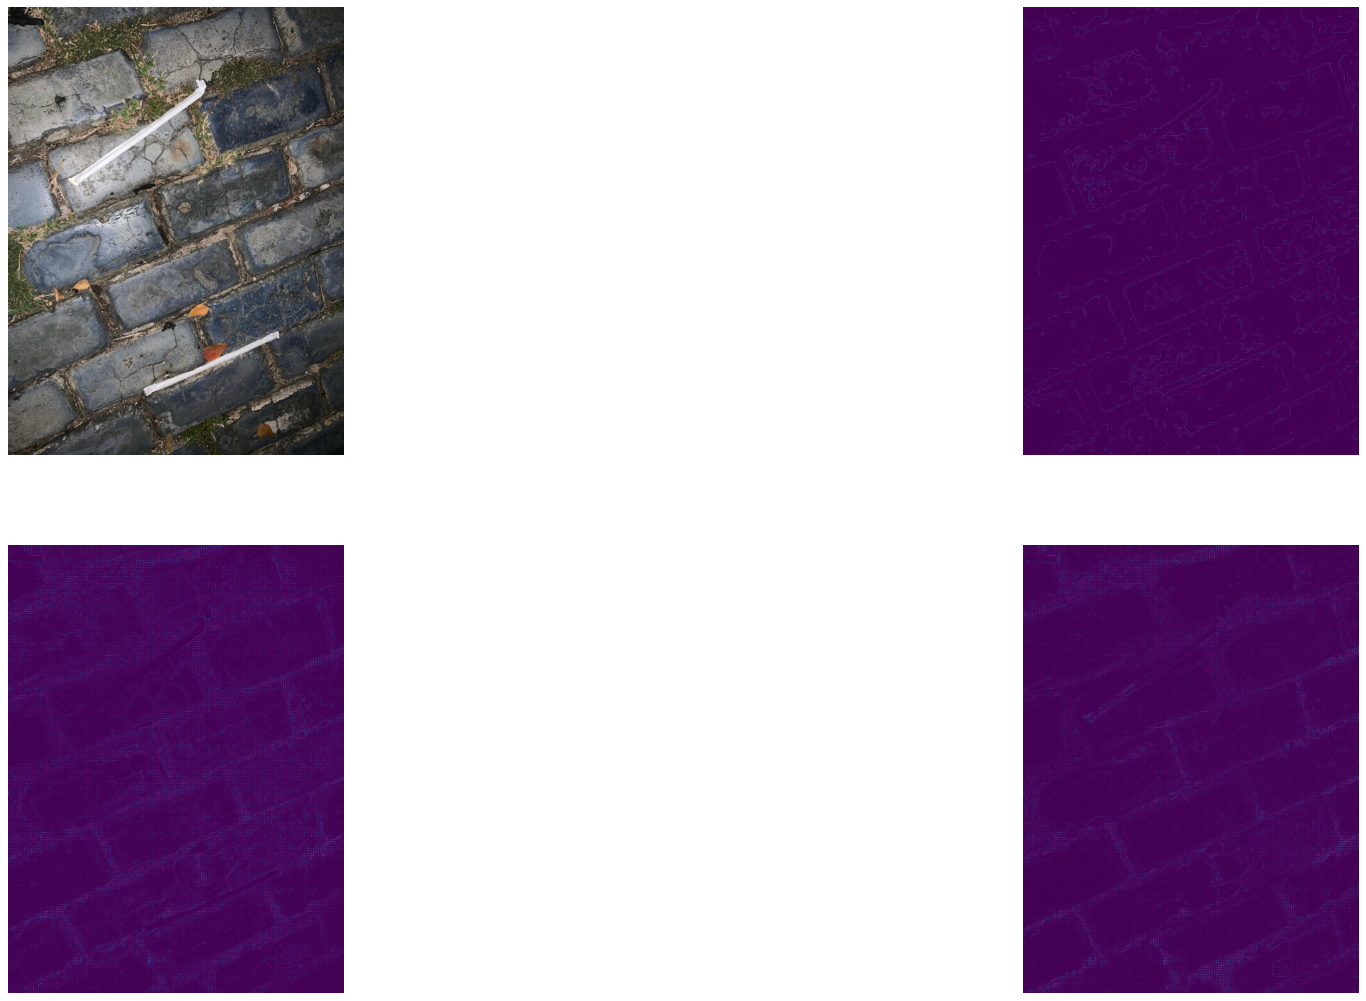

In [10]:
if(features == "canny"):
    original_img, feature_img = src.visualize()
    
    fig, ax = plt.subplots(1, 2, figsize = (15, 8), dpi = 80)
    ax = ax.ravel()
    ax[0].imshow(original_img)
    ax[1].imshow(feature_img)
    for i in range(2):
      ax[i].axis('off')
elif(features == "hog"):
    original_img, feature1_img, feature2_img, feature3_img = src.visualize()
    
    fig, ax = plt.subplots(2, 2, figsize = (30, 16), dpi = 80)
    ax = ax.ravel()
    ax[0].imshow(original_img)
    ax[1].imshow(feature1_img)
    ax[2].imshow(feature2_img)
    ax[3].imshow(feature3_img)
    for i in range(4):
      ax[i].axis('off')
    


### Compute heatmap and apply a threshold to it in order to reduce the effect of noisy detections

WINDOW SIZE  64   48


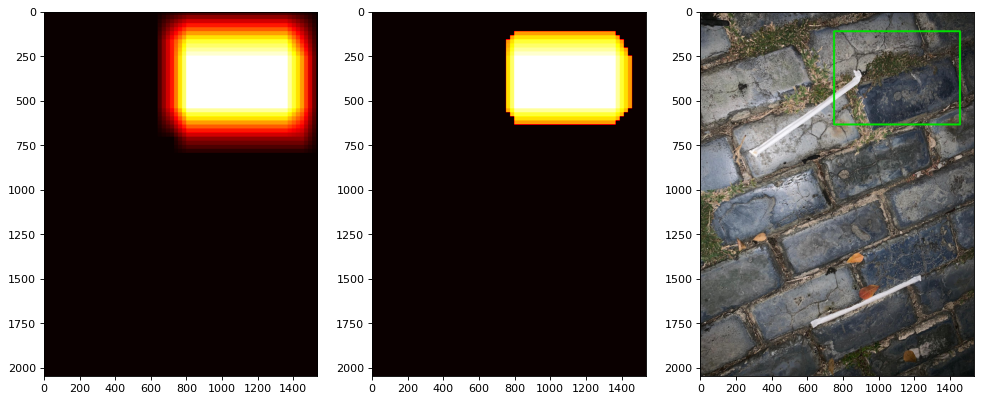

In [11]:
heatmap = HeatMap(frame = img, memory = 4)
heatmap_test(img, heatmap)

## Segment the object proposals and obtain the final image

## Object proposals + segmentation on each image of the dataset in sequence 

 REGION SHAPE  (523, 706, 3)


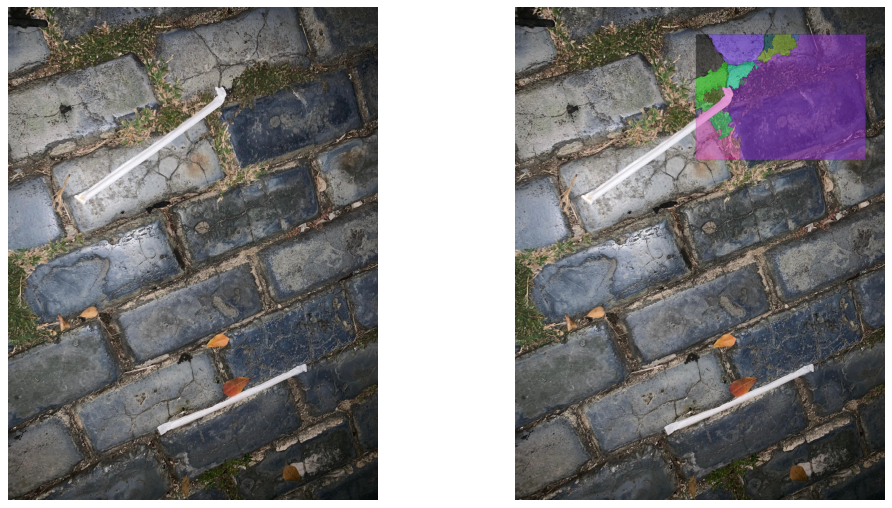

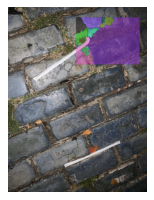

In [12]:
object_proposals = heatmap.get_final_bounding_boxes()
            
fig, ax = plt.subplots(1, 2, figsize = (15, 8), dpi = 80)
ax = ax.ravel()

segmenter = WatershedSegmenter(img, object_proposals)

#show_images([img1], per_row = len(object_proposals), per_col = 1, W = 15, H = 3)
segmented_object_proposals = segmenter.segment_object_proposals()


final_image= segmenter.build_final_image(segmented_object_proposals)
show_images([final_image], per_row = len(object_proposals), per_col = 1, W = 15, H = 3)
ax[0].imshow(img)
ax[1].imshow(final_image)
for i in range(2):
  ax[i].axis('off')

WINDOW SIZE  64   48


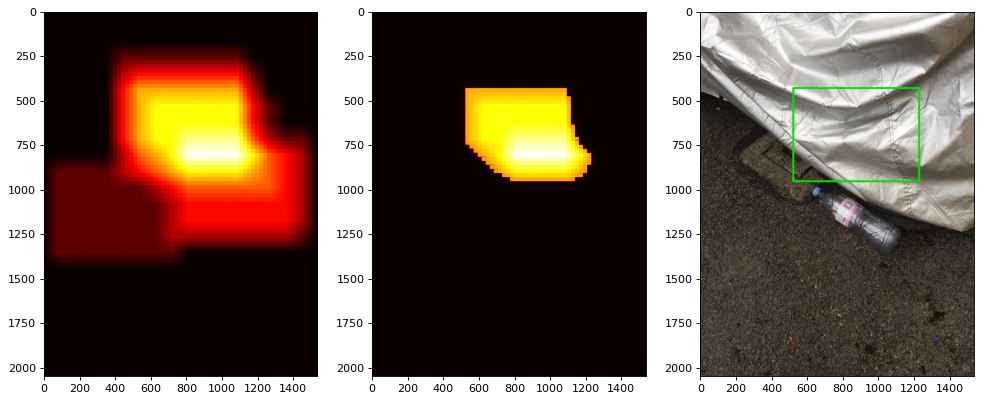

 REGION SHAPE  (523, 706, 3)


KeyboardInterrupt: 

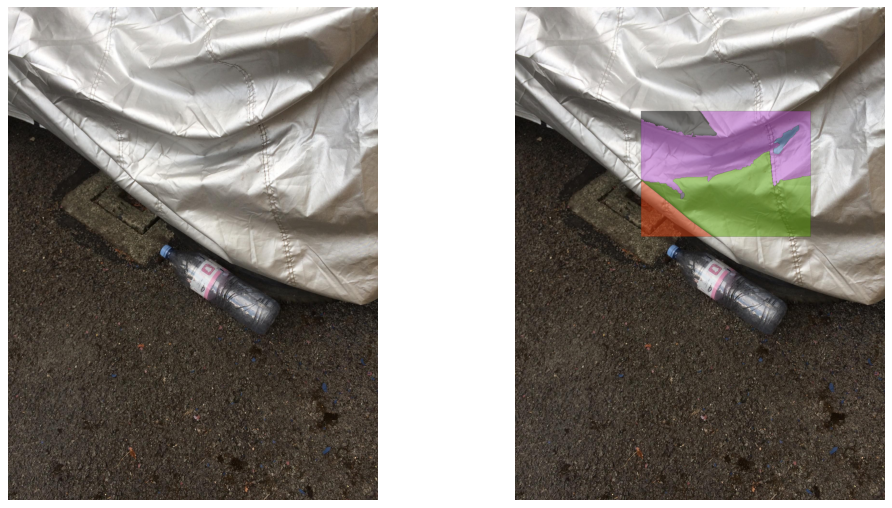

In [13]:
path = "../../data/test"
subdirs = [x[0] for x in os.walk(path)]                                                                            
for subdir in subdirs:                                                                                            
    files = os.walk(subdir).__next__()[2]                                                                             
    if (len(files) > 0):                                                                                          
        for file in files:    
            img_path = os.path.join(subdir,file)
            if(features == "canny"):
                src = CannyFeatureExtractor(sourcer_params, iio.imread(img_path))
            elif(features == "hog"):
                src = HogFeatureExtractor(sourcer_params, iio.imread(img_path))

            slider = Slider(sourcer = src, classifier = cls, increment = 8)

            img1 = iio.imread(img_path)

            heatmap = HeatMap(frame = img1, memory = 4)
            heatmap_test(img1, heatmap, "/home/filippo/GarbageDetectionAndSegmentation/data/saved_experiments/" + file)
            
            object_proposals = heatmap.get_final_bounding_boxes()
            
            fig, ax = plt.subplots(1, 2, figsize = (15, 8), dpi = 80)
            ax = ax.ravel()
            
            segmenter = WatershedSegmenter(img1, object_proposals)
            
            #show_images([img1], per_row = len(object_proposals), per_col = 1, W = 15, H = 3)
            segmented_object_proposals = segmenter.segment_object_proposals()
            
            
            final_image= segmenter.build_final_image(segmented_object_proposals)
            #show_images([final_image], per_row = len(object_proposals), per_col = 1, W = 15, H = 3)
            ax[0].imshow(img1)
            ax[1].imshow(final_image)
            for i in range(2):
              ax[i].axis('off')